# AML Assignment 2: Link Prediction with NASA GES-DISC Dataset

Objective: Apply two link prediction methods to the NASA GES-DISC knowledge graph dataset.

## Part 1: Exploring the NASA GES-DISC Dataset
● Task: Download and explore the NASA GES-DISC dataset.
● Dataset Link: https://zenodo.org/record/11492533
● Description: Analyze node types, edges, and relationships. Provide basic statistics,
including node and edge counts and any significant relationships.
Deliverable:
● Code to load the dataset using PyTorch Geometric (PyG) or another library.
● Print summary of the dataset’s structure and key statistics.

**Data Loading:**

First, I will deal with the data by reading from `nodes.csv` and loading them into a dictionary for easier access and manipulation.

Import Libraries

In [292]:
# Basic Libraries
import csv
import random
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

# Graph and Visualization
import networkx as nx
from itertools import chain
from matplotlib import cm

# Embeddings and Machine Learning
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

# Other Utilities
from collections import Counter


In [293]:
import csv
import random

# 读取 nodes.csv 文件并创建 id_to_index 映射
nodes = {}
id_to_index = {}  # id 到节点编号的映射
index = 0

with open('20241011_AML_HW2_Code/data/nodes.csv', mode='r', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        node_id = row['id']
        label = row['label']
        properties = row['properties']
        
        # 保存节点数据
        nodes[node_id] = [label, properties]
        
        # 为每个节点创建索引编号映射
        id_to_index[node_id] = index
        index += 1

# 随机展示5个节点数据
random_sample = random.sample(list(nodes.items()), 5)
for key, value in random_sample:
    print(f"ID: {key}, Label: {value[0]}, Properties: {value[1]}")

# 随机展示5个 id 到 index 的映射
random_id_index_sample = random.sample(list(id_to_index.items()), 5)
print("\nSample of ID to Index Mapping:")
for node_id, idx in random_id_index_sample:
    print(f"Node ID: {node_id}, Index: {idx}")


ID: 23801, Label: ['ScienceKeyword'], Properties: {'name': 'ATMOSPHERIC HEATING', 'globalId': '5850173d-1e26-5ba9-a1db-4ecf1f1d05b6'}
ID: 374, Label: ['Dataset'], Properties: {'abstract': 'ML2CO is the EOS Aura Microwave Limb Sounder (MLS) standard product for carbon monoxide derived from radiances measured by the 640 GHz radiometer. The data version is 5.0. Data coverage is from August 8, 2004 to current. Spatial coverage is near-global (-82 degrees to +82 degrees latitude), with each profile spaced 1.5 degrees or ~165 km along the orbit track (roughly 15 orbits per day). The recommended useful vertical range is between 215 and 0.00564 hPa, and the vertical resolution is about 6 km. Users of the ML2CO data product should read section 3.7 of the EOS MLS Level 2 Version 5 Quality Document for more information.The data are stored in the version 5 EOS Hierarchical Data Format (HDF-EOS5), which is based on the version 5 Hierarchical Data Format, or HDF-5. Each file contains two swath objec

**Data Preprocessing:**

The `properties` field in the nodes data is a string representation of a dictionary. I need to parse this string into an actual dictionary to access individual property values for each node. This will allow me to utilize node attributes effectively when building the graph.


In [294]:
for key, value in nodes.items():
    properties_str = value[1]
    properties_dict = ast.literal_eval(properties_str)
    nodes[key][1] = properties_dict
random_sample = random.sample(list(nodes.items()), 5)
for key, value in random_sample:
    print(key, type(value[1]),value)


2865 <class 'dict'> ["['Publication']", {'Year': '2023', 'globalId': '4287fc40-4c3d-5d52-89b8-c805e448ebb3', 'DOI': '10.3390/RS15010227', 'Title': 'PrecipGradeNet: A New Paradigm and Model for Precipitation Retrieval'}]
3957 <class 'dict'> ["['Publication']", {'Year': '2020', 'globalId': '60c1ef90-95b4-55cc-9ce4-3cb5be2e55d1', 'DOI': '10.1029/2020GH000281', 'Title': 'Environmental Association of Burning Agricultural Biomass in the Indus River Basin'}]
523 <class 'dict'> ["['Dataset']", {'abstract': 'Version 07 is the current version of the data set. Older versions will no longer be available and have been superseded by Version 07.3GPROF products provide global gridded monthly/daily precipitation averages from multiple satellites that can be used for climate studies. The 3GPROF products are based on retrievals from high-quality microwave sensors, which are sensitive to liquid and ice-phase precipitation hydrometeors in the atmosphere.', 'daac': 'NASA/GSFC/SED/ESD/GCDC/GESDISC', 'longNam

**Graph Construction:**

I will construct a directed graph using NetworkX. Nodes will be added to the graph with their respective attributes based on their types. This will help in capturing the relationships between different entities in the dataset.


In [295]:
# Initialize directed graph
G = nx.DiGraph()

for key, value in nodes.items():
    # Clean up the type field
    cleaned_type = value[0].strip("[]'\"")
    
    # Add node with attributes based on type
    properties = value[1]
    if cleaned_type == 'Dataset':
        G.add_node(key, type=cleaned_type,
                   abstract=properties.get('abstract', 'N/A'),
                   daac=properties.get('daac', 'N/A'),
                   longName=properties.get('longName', 'N/A'),
                   globalId=properties.get('globalId', 'N/A'),
                   shortName=properties.get('shortName', 'N/A'),
                   doi=properties.get('doi', 'N/A'))
    
    elif cleaned_type == 'DataCenter':
        G.add_node(key, type=cleaned_type,
                   longName=properties.get('longName', 'N/A'),
                   globalId=properties.get('globalId', 'N/A'),
                   shortName=properties.get('shortName', 'N/A'),
                   url=properties.get('url', 'N/A'))
    
    elif cleaned_type == 'Project':
        G.add_node(key, type=cleaned_type,
                   longName=properties.get('longName', 'N/A'),
                   globalId=properties.get('globalId', 'N/A'),
                   shortName=properties.get('shortName', 'N/A'))
    
    elif cleaned_type == 'Platform':
        G.add_node(key, type=cleaned_type,
                   platformType=properties.get('Type', 'N/A'),
                   longName=properties.get('longName', 'N/A'),
                   globalId=properties.get('globalId', 'N/A'),
                   shortName=properties.get('shortName', 'N/A'))
    
    elif cleaned_type == 'Instrument':
        G.add_node(key, type=cleaned_type,
                   longName=properties.get('longName', 'N/A'),
                   globalId=properties.get('globalId', 'N/A'),
                   shortName=properties.get('shortName', 'N/A'))
    
    elif cleaned_type == 'Publication':
        G.add_node(key, type=cleaned_type,
                   year=properties.get('Year', 'N/A'),
                   globalId=properties.get('globalId', 'N/A'),
                   doi=properties.get('DOI', 'N/A'),
                   title=properties.get('Title', 'N/A'))
    
    elif cleaned_type == 'ScienceKeyword':
        G.add_node(key, type=cleaned_type,
                   name=properties.get('name', 'N/A'),
                   globalId=properties.get('globalId', 'N/A'))
    
    else:
        # Print unhandled types
        print(f"Unhandled type: {cleaned_type}")

# Print total nodes and a sample
print('Total nodes:', G.number_of_nodes())

sample_nodes = random.sample(list(G.nodes(data=True)), 3)
print("Sample nodes with attributes:")
for node_id, attrs in sample_nodes:
    print(f"Node ID: {node_id}, Attributes: {attrs}")


Total nodes: 5763
Sample nodes with attributes:
Node ID: 19885, Attributes: {'type': 'Publication', 'year': '2023', 'globalId': '094f661d-5bd3-50a3-a31d-ebd8f1211f52', 'doi': '10.1016/J.GEOMORPH.2023.108665', 'title': 'Geomorphometric characterization and sediment connectivity of the middle'}
Node ID: 13853, Attributes: {'type': 'Publication', 'year': '2022', 'globalId': '3f98a8b9-f84b-52e9-bd88-91ec120f8115', 'doi': '10.1029/2022GL100973', 'title': 'Link between the time‐space behavior of rainfall and 3D dynamical structures of equatorial waves in global convection‐permitting simulations'}
Node ID: 1239, Attributes: {'type': 'Dataset', 'abstract': 'This is the new (GPM-formated) TRMM product. It replaces the old TRMM legacy product TRMM_3G31.Version 07 is the current version of the data set. Older versions will no longer be available and have been superseded by Version 07.Estimating vertical profiles of latent heating released by precipitating cloud systems is one of the key objective

In [296]:
# Load edges from train_edges.csv and add to the graph
with open('20241011_AML_HW2_Code/data/train_edges.csv', mode='r', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Add edge with relationship type
        G.add_edge(row['source'], row['target'], relationship_type=row['relationship_type'])

# Print total number of edges
print('Total edges:', G.number_of_edges())


Total edges: 13820


**Data Visualization:**

To better understand the structure of the graph, I will visualize the 3-layer neighborhood of randomly selected nodes. This will help me see how nodes are connected and the types of relationships present in the graph.


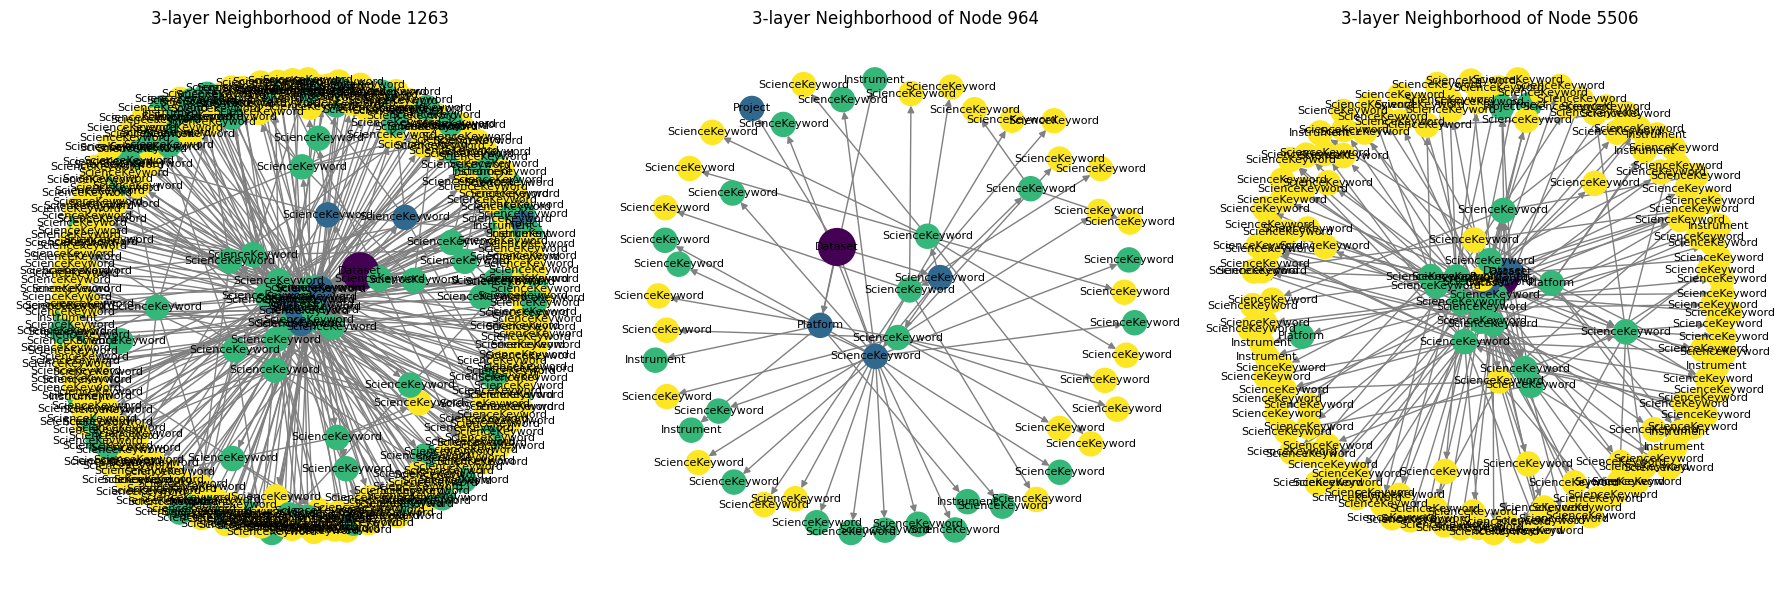

In [297]:
def plot_n_layer_neighborhood(G, n_layers=4, ax=None):
    # Generate subgraph of n-layer neighborhood
    subgraph_nodes = set()
    
    # Ensure at least 10 nodes in subgraph
    while len(subgraph_nodes) < 10:
        random_node_id = random.choice(list(G.nodes))

        # Use BFS to find n-layer neighbors
        layers_nodes = {0: {random_node_id}}
        for layer in range(1, n_layers + 1):
            neighbors = set(chain.from_iterable(G.neighbors(node) for node in layers_nodes[layer - 1]))
            neighbors -= set(chain.from_iterable(layers_nodes.values()))  # Remove visited nodes
            layers_nodes[layer] = neighbors

        # Merge layers into final set of nodes
        subgraph_nodes = set(chain.from_iterable(layers_nodes.values()))

    subgraph = G.subgraph(subgraph_nodes)
    pos = nx.spring_layout(subgraph, seed=42)

    # Color gradient based on layers
    colors = cm.viridis(np.linspace(0, 1, n_layers + 1))

    # Assign colors and sizes to nodes
    node_colors = []
    for node in subgraph:
        for layer, nodes in layers_nodes.items():
            if node in nodes:
                node_colors.append(colors[layer])
                break
    
    node_sizes = [700 if node == random_node_id else 300 for node in subgraph]

    # Get node type as labels
    labels = {node: subgraph.nodes[node].get('type', 'Unknown') for node in subgraph}

    # Draw nodes and edges
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True, ax=ax)
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8, ax=ax)

    ax.set_title(f"{n_layers}-layer Neighborhood of Node {random_node_id}")
    ax.axis('off')

# Create 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot neighborhoods in each subplot
for ax in axes:
    plot_n_layer_neighborhood(G, n_layers=3, ax=ax)

plt.tight_layout()
plt.show()


In [298]:
# Select a random node ID
random_node_id = random.choice(list(G.nodes))
print(f"Randomly selected Node ID: {random_node_id}")

# Print attributes of the selected node
node_attributes = G.nodes[random_node_id]
print("\nNode Attributes:")
for attr, value in node_attributes.items():
    print(f"  {attr}: {value}")

# Get and print outgoing edges from the node
out_edges = G.out_edges(random_node_id, data=True)
print("\nOutgoing connections (edges):")
for _, target_node, data in out_edges:
    print(f" -> Target Node ID: {target_node}, Relationship Type: {data.get('relationship_type')}")

# Get and print incoming edges to the node
in_edges = G.in_edges(random_node_id, data=True)
print("\nIncoming connections (edges):")
for source_node, _, data in in_edges:
    print(f" <- Source Node ID: {source_node}, Relationship Type: {data.get('relationship_type')}")


Randomly selected Node ID: 417

Node Attributes:
  type: Dataset
  abstract: The Climate Hyperspectral Infrared Radiance Product (CHIRP) is a Level 1 radiance product derived from Atmospheric Infrared Sounder (AIRS) on EOS-AQUA and the Cross-Track Infrared Sounders (CrIS) on the SNPP and JPSS-1+ platforms.  (JPSS-1 is also called NOAA-20). CHIRP provides a consistent spectral response function (SRF) across all instruments. Inter-instrument radiometric offsets are removed with SNPP-CrIS chosen as the "standard".  CHIRP follows the original instrument storage, i.e., granule in, granule out, and contains all information needed for retrievals (including cross-track, along-track, fov id, etc.). This version of CHIRP, SNDR13CHRP1J1Cal, contains CHIRP data derived from the JPSS-1 (NOAA-20) CrIS instrument that is not present in the main CHIRP product, SNDR13CHRP1, which include JPSS-1 data from February 17, 2018 through August 31, 2018.
  daac: NASA/GSFC/SED/ESD/GCDC/GESDISC
  longName: Sound

**Graph Statistics Analysis:**

I will analyze the graph to extract key statistics such as:

- Total number of nodes and edges.
- Counts of different node types.
- Counts of different relationship types.
- Degree distribution, including top nodes by degree and average degree.

This analysis will provide insights into the overall structure and characteristics of the knowledge graph.


In [299]:
from collections import Counter

def analyze_graph_statistics(G):
    # Get total nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Count node types and relationship types
    node_types = [G.nodes[node].get('type', 'Unknown') for node in G.nodes]
    node_type_counts = Counter(node_types)
    relationship_types = [G.edges[edge].get('relationship_type', 'Unknown') for edge in G.edges]
    relationship_type_counts = Counter(relationship_types)

    # Calculate degree distribution
    degree_sequence = sorted([(node, deg) for node, deg in G.degree()], key=lambda x: x[1], reverse=True)
    top_5_nodes = degree_sequence[:5]
    avg_degree = sum(deg for _, deg in degree_sequence) / num_nodes if num_nodes > 0 else 0

    # Print statistics
    print("Graph Statistics:")
    print(f"Total nodes: {num_nodes}")
    print(f"Total edges: {num_edges}\n")

    print("Node Type Counts:")
    for node_type, count in node_type_counts.items():
        print(f"  {node_type}: {count}")

    print("\nRelationship Type Counts:")
    for rel_type, count in relationship_type_counts.items():
        print(f"  {rel_type}: {count}")

    print("\nDegree Distribution:")
    for i, (node_id, degree) in enumerate(top_5_nodes, start=1):
        node_type = G.nodes[node_id].get('type', 'Unknown')
        print(f"  Top {i} Node ID: {node_id}, Degree: {degree}, Type: {node_type}")

    print(f"  Average degree: {avg_degree:.2f}")

# Run analysis
analyze_graph_statistics(G)


Graph Statistics:
Total nodes: 5763
Total edges: 13820

Node Type Counts:
  Dataset: 1300
  DataCenter: 1
  Project: 44
  Platform: 142
  Instrument: 83
  Publication: 2584
  ScienceKeyword: 1609

Relationship Type Counts:
  HAS_SCIENCEKEYWORD: 4015
  OF_PROJECT: 1325
  HAS_PLATFORM: 1519
  HAS_DATASET: 1300
  HAS_INSTRUMENT: 215
  USES_DATASET: 3623
  SUBCATEGORY_OF: 1823

Degree Distribution:
  Top 1 Node ID: 1317, Degree: 1300, Type: DataCenter
  Top 2 Node ID: 23689, Degree: 786, Type: ScienceKeyword
  Top 3 Node ID: 1049, Degree: 392, Type: Dataset
  Top 4 Node ID: 23723, Degree: 342, Type: ScienceKeyword
  Top 5 Node ID: 23837, Degree: 331, Type: ScienceKeyword
  Average degree: 4.80


## Part 2: Link Prediction

I will implement two link prediction methods to predict missing links in the knowledge graph.


### Method 1: Embedding-Based Approach Using Node2Vec

In this method, I use Node2Vec to generate embeddings for each node in the graph. These embeddings capture the structural relationships between nodes. I then use logistic regression to predict the likelihood of an edge existing between two nodes based on their embeddings.

**Steps:**

- Generate node embeddings using Node2Vec.
- Create positive and negative samples for link prediction.
- Train a logistic regression model on the training data.
- Evaluate the model using AUC, F1 Score, and Accuracy metrics.


In [300]:
val_links = pd.read_csv('20241011_AML_HW2_Code/data/val_links.csv')
test_links = pd.read_csv('20241011_AML_HW2_Code/data/test_links.csv')

val_positive_edges = list(zip(val_links['source'].astype(str), val_links['target'].astype(str)))
test_positive_edges = list(zip(test_links['source'].astype(str), test_links['target'].astype(str)))

val_positive_edges[:5], test_positive_edges[:5]


([('1144', '23689'),
  ('1016', '23689'),
  ('1298', '24881'),
  ('348', '23780'),
  ('876', '23715')],
 [('545', '24190'),
  ('867', '24623'),
  ('962', '23690'),
  ('857', '23715'),
  ('242', '23819')])

use random walk node2vec to get a vector for each node

In [301]:
def generate_embeddings(G, dimensions=64, walk_length=30, num_walks=200):
    # Node2Vec model
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    # Generate embeddings as a dictionary
    return {str(node): model.wv[str(node)] for node in G.nodes()}

# Generate embeddings
embeddings = generate_embeddings(G)


Computing transition probabilities: 100%|██████████| 5763/5763 [00:00<00:00, 25699.04it/s]


In [302]:


# Display a sample of 5 node embeddings
print("Sample of Node Embeddings:")
for node, embedding in list(embeddings.items())[:2]:
    print(f"Node ID: {node}\nEmbedding: {embedding[:10]}...")  # Display first 10 values for brevity


Sample of Node Embeddings:
Node ID: 0
Embedding: [-0.22672147 -0.39705986  0.44190457  0.37042144 -0.14372551 -0.4407172
  0.2565194  -0.5656797  -0.6715802   0.18195057]...
Node ID: 1
Embedding: [ 0.33862886 -0.702588    0.46532625  1.1669219  -0.4272426  -1.2474974
  0.21932796  0.29025015 -0.13226187 -0.2821724 ]...


Generate positive and negative samples for future model training

In [303]:
def create_link_prediction_data(positive_edges, embeddings, G=None, exclude_edges=None):
    X, y = [], []
    exclude_edges = exclude_edges or set()

    # Create positive samples
    for u, v in positive_edges:
        X.append(np.concatenate((embeddings[u], embeddings[v])))
        y.append(1)
    
    # Create negative samples
    if G:
        nodes = list(G.nodes())
        negative_edges = []
        while len(negative_edges) < len(positive_edges):
            u, v = random.choice(nodes), random.choice(nodes)
            if u != v and not G.has_edge(u, v) and (u, v) not in exclude_edges:
                negative_edges.append((u, v))

        for u, v in negative_edges:
            X.append(np.concatenate((embeddings[u], embeddings[v])))
            y.append(0)
            
    return np.array(X), np.array(y)



In [304]:
# Generate training data from positive edges, excluding test edges
positive_edges = list(G.edges())
X_train, y_train = create_link_prediction_data(positive_edges, embeddings, G, exclude_edges=set(test_positive_edges))

# Generate validation data from validation edges
X_val, y_val = create_link_prediction_data(val_positive_edges, embeddings, G, exclude_edges=set(val_positive_edges))

# Generate test data from test edges
X_test, y_test = create_link_prediction_data(test_positive_edges, embeddings, G)


Use Logistic Regression to train

In [305]:
def train_model(X_train, y_train):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    return clf

Evaluate by builtin auc, f1 and accuracy score

In [306]:
def evaluate_model(clf, X, y):
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)[:, 1]
    
    auc = roc_auc_score(y, y_proba) if len(set(y)) > 1 else None
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    
    # Return metrics as a dictionary
    return {
        "AUC": auc,
        "F1 Score": f1,
        "Accuracy": accuracy
    }


Train by train dataset and use val dataset to evaluate

In [307]:
# Train model on the training set
clf = train_model(X_train, y_train)

# Evaluate model on the test set
print("\nTest Set Evaluation:")
test_metrics = evaluate_model(clf, X_test, y_test)

# Print evaluation metrics
print(f"  AUC = {test_metrics['AUC']}")
print(f"  F1 Score = {test_metrics['F1 Score']}")
print(f"  Accuracy = {test_metrics['Accuracy']}")



Test Set Evaluation:
  AUC = 0.9694167573831041
  F1 Score = 0.9328235936646642
  Accuracy = 0.9285714285714286


### Method 2: Alternative Approach Using Singular Value Decomposition (SVD)

For the second method, I apply SVD to the adjacency matrix of the graph to obtain low-dimensional representations of the nodes. I then predict links by computing the dot product of node embeddings.

**Steps:**

- Construct the adjacency matrix of the graph.
- Perform SVD to obtain node embeddings.
- Generate positive and negative samples for evaluation.
- Compute similarity scores and evaluate the model using AUC, F1 Score, and Accuracy metrics.


In [308]:
import numpy as np
from scipy.sparse.linalg import svds
import networkx as nx

# Construct adjacency matrix from NetworkX graph G
adj_matrix = nx.to_numpy_array(G)
print("Adjacency Matrix:")
print(adj_matrix)

# Display matrix statistics
print("\nMatrix Statistics:")
print("Dimensions (rows, columns):", adj_matrix.shape)
print("Number of nodes:", adj_matrix.shape[0])
print("Is the matrix square?", adj_matrix.shape[0] == adj_matrix.shape[1])
print("Matrix dtype:", adj_matrix.dtype)
print("Sum of elements (edge count):", np.sum(adj_matrix))
print("Maximum value (edge presence):", np.max(adj_matrix))
print("Minimum value (usually 0):", np.min(adj_matrix))
print("Mean value:", np.mean(adj_matrix))
print("Maximum row sum:", np.max(np.sum(adj_matrix, axis=1)))


Adjacency Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]

Matrix Statistics:
Dimensions (rows, columns): (5763, 5763)
Number of nodes: 5763
Is the matrix square? True
Matrix dtype: float64
Sum of elements (edge count): 13820.0
Maximum value (edge presence): 1.0
Minimum value (usually 0): 0.0
Mean value: 0.0004161125399548581
Maximum row sum: 1300.0


In [309]:
def generate_negative_samples(positive_edges, num_samples, node_list):
    """Generate negative sample edges."""
    negative_edges = set()
    while len(negative_edges) < num_samples:
        u = np.random.choice(node_list)
        v = np.random.choice(node_list)
        if (u, v) not in positive_edges and (v, u) not in positive_edges and u != v:
            negative_edges.add((u, v))
    return list(negative_edges)


def evaluate_model(adj_matrix, positive_edges, k, id_to_index):
    """Evaluate AUC, F1 Score, and Accuracy using SVD embeddings."""
    # Perform SVD decomposition
    u, s, vt = svds(adj_matrix, k=k)
    node_embeddings = u @ np.diag(s)
    
    # Score positive samples
    pos_scores = [
        np.dot(node_embeddings[id_to_index[u]], node_embeddings[id_to_index[v]])
        for u, v in positive_edges
    ]
    
    # Generate and score negative samples
    node_list = list(id_to_index.keys())
    negative_edges = generate_negative_samples(
        set(positive_edges), len(positive_edges), node_list
    )
    neg_scores = [
        np.dot(node_embeddings[id_to_index[u]], node_embeddings[id_to_index[v]])
        for u, v in negative_edges
    ]
    
    # Compute evaluation metrics
    labels = [1] * len(pos_scores) + [0] * len(neg_scores)
    scores = pos_scores + neg_scores
    auc = roc_auc_score(labels, scores)
    
    # Set threshold to classify samples; calculate F1 Score and Accuracy
    threshold = 0
    predictions = [1 if score >= threshold else 0 for score in scores]
    f1 = f1_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    
    # Return metrics as a dictionary
    return {
        "AUC": auc,
        "F1 Score": f1,
        "Accuracy": accuracy
    }


In [313]:
def binary_search_optimal_k(adj_matrix, val_positive_edges, id_to_index, min_k=5, max_k=50, tolerance=5):
    best_k = min_k
    best_auc = 0
    best_metrics = {}

    while max_k - min_k > tolerance:
        mid_k = (min_k + max_k) // 2

        # Evaluate model at mid_k
        metrics = evaluate_model(adj_matrix, val_positive_edges, mid_k, id_to_index)
        auc = metrics["AUC"]
        f1 = metrics["F1 Score"]
        accuracy = metrics["Accuracy"]
        print(f"Testing k = {mid_k}, AUC = {auc}, F1 Score = {f1}, Accuracy = {accuracy}")
        
        # Update best metrics if current mid_k is better and AUC is valid
        if auc is not None and auc > best_auc:
            best_auc = auc
            best_k = mid_k
            best_metrics = metrics

        # Adjust the search range
        if auc is not None and auc > best_auc:
            min_k = mid_k + 1
        else:
            max_k = mid_k - 1

        print(f"Updated search range: min_k = {min_k}, max_k = {max_k}")

    print(f'Optimal k found: {best_k}, with metrics: {best_metrics}')
    return best_k, best_metrics


best_k, best_metrics = binary_search_optimal_k(adj_matrix, val_positive_edges, id_to_index)

Testing k = 27, AUC = 0.6502866414277988, F1 Score = 0.5633251833740831, Accuracy = 0.4808139534883721
Updated search range: min_k = 5, max_k = 26
Testing k = 15, AUC = 0.6292928610059491, F1 Score = 0.5585844093735055, Accuracy = 0.4633720930232558
Updated search range: min_k = 5, max_k = 14
Testing k = 9, AUC = 0.5877501352082206, F1 Score = 0.5386416861826698, Accuracy = 0.4273255813953488
Updated search range: min_k = 5, max_k = 8
Optimal k found: 27, with metrics: {'AUC': 0.6502866414277988, 'F1 Score': 0.5633251833740831, 'Accuracy': 0.4808139534883721}


In [314]:
# Evaluate the model with the best k on the test set
test_metrics = evaluate_model(adj_matrix, test_positive_edges, best_k, id_to_index)

# Print test set evaluation metrics
print(f"Best k value on test set:")
print(f"  AUC = {test_metrics['AUC']}")
print(f"  F1 Score = {test_metrics['F1 Score']}")
print(f"  Accuracy = {test_metrics['Accuracy']}")


Best k value on test set:
  AUC = 0.5950418239871796
  F1 Score = 0.5241110569897711
  Accuracy = 0.4326364692218351


## Part 3: Reflection on the Performance of Each Method

### Method 1: Embedding-Based Approach Using Node2Vec

- **Performance Metrics on Test Set:**
  - **AUC:** 0.9694
  - **F1 Score:** 0.9328
  - **Accuracy:** 92.86%

The embedding-based approach using Node2Vec delivered excellent results. The high AUC of **0.9694** indicates a strong ability to distinguish between positive and negative links. The impressive F1 Score and accuracy demonstrate that the model effectively captured the complex relationships within the knowledge graph, leading to accurate link predictions.

**Reflection and Improvement:**

- The success of this method suggests that Node2Vec embeddings are effective in representing the structural features of the graph.
- **Possible Improvement:** To further enhance this method, I can incorporate additional node properties (attributes) when generating embeddings. By integrating more descriptive features of the nodes, the embeddings may better represent the underlying characteristics, potentially improving the model's performance even further.

### Method 2: Alternative Approach Using Singular Value Decomposition (SVD)

- **Performance Metrics on Test Set:**
  - **AUC:** 0.5950
  - **F1 Score:** 0.5241
  - **Accuracy:** 43.26%

The SVD-based method performed significantly worse than the embedding-based approach. An AUC close to 0.5 suggests that the model is only marginally better than random guessing. The low F1 Score and accuracy indicate that the method struggled to make accurate link predictions.

**Reflection and Improvement:**

- The poor performance may be due to SVD's limitations in capturing complex, non-linear relationships inherent in the graph data.
- **Possible Improvement:** SVD might not be suitable for this task. In future work, I could try different approaches such as:

  - **Heuristic-Based Methods:** Implement algorithms like Common Neighbors or Adamic-Adar Index that leverage local graph structures for link prediction.
  - **Advanced Graph Models:** Utilize Graph Neural Networks (GNNs) or other deep learning techniques designed for graph data to better model the intricate patterns within the network.

### Overall Reflection

- **Comparison:** Method 1 outperformed Method 2 by a significant margin across all evaluation metrics. This highlights the effectiveness of embedding-based approaches in capturing complex graph structures for link prediction tasks.
- **Challenges:** The main challenge with Method 2 was its inability to capture non-linear relationships, which are prevalent in the dataset.
- **Insights:** The results emphasize the importance of selecting appropriate methods that align with the complexity of the data. Embedding techniques that capture higher-order relationships are more suitable for such tasks.

**Future Work:**

- For **Method 1**, integrating node attributes into the embeddings could potentially improve performance.
- For **Method 2**, exploring alternative methods better suited to the data's complexity is necessary. Heuristic-based methods or advanced graph neural networks might provide better results.

By considering these improvements, I aim to enhance the predictive capabilities of the models and achieve more robust link prediction results in future work.

# Thank you

Shi Qiu

20241107